In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import Tensor, optim, cuda
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import Tensor, optim, cuda
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import csv
import os
from tensorboardX import SummaryWriter
from sklearn.metrics import roc_auc_score, accuracy_score

from tqdm import tqdm_notebook as tqdm

from data.datasets import DeClareDataset
from model.deClare import DeClareModel
from metrics.evaluation import DeClareEvaluation

In [2]:
torch.cuda.is_available()

True

# Load Datasets

In [3]:
SNOPES_LOC = "./Datasets/Snopes/snopes.tsv"
#consists of rumors analyzed on the Snopes website along with their credibility labels (true or false), 
#sets of reporting articles, and their respective web sources

POLITIFACT_LOC = "./Datasets/PolitiFact/politifact.tsv"

glove_data_file = "./Glove/glove.6B.100d.txt"

In [4]:
snopes = DeClareDataset(SNOPES_LOC, glove_data_file)

Successfully read news data from ./Datasets/Snopes/snopes.tsv
Number of articles = 29242
Number of claims = 4341
Using pre-built vocabulary


In [5]:
snopes.news_df.head()

,Credibility,Claim_Source,Claim,Article,Article_Source
0,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,there are several holidays throughout that tim...,www.godlikeproductions.com
1,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,defenses against same photographs show images ...,www.sjpba.net
2,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,the best that life could think out we extended...,www.englisher.net
3,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,this entry november 19 2006 published 9 years ...,rss2.com
4,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,place he will not do either said snape the ord...,www.englisher.net


## Preliminary Analysis

In [23]:
batch_size = 64
nb_lstm_units = 64
random_seed = 42

val_split = 0.1
test_split = 0.1
shuffle_dataset = False

In [24]:
# Creating data indices for training and validation splits:
dataset_size = len(snopes)
indices = list(range(dataset_size))

val_split = int(np.floor(val_split * dataset_size))
test_split = val_split + int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[test_split:], indices[:val_split], indices[val_split:test_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [25]:
train_dataloader = DataLoader(snopes, batch_size, sampler=train_sampler)
val_dataloader = DataLoader(snopes, len(val_indices), sampler=val_sampler)
test_dataloader = DataLoader(snopes, len(test_indices), sampler=test_sampler)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
declare = DeClareModel(snopes.initial_embeddings, snopes.claim_source_vocab_size, 
                       snopes.article_source_vocab_size, nb_lstm_units, device)

declare.to(device)

DeClareModel(
  (word_embeddings): Embedding(56755, 100)
  (claim_source_embeddings): Embedding(4342, 4)
  (article_source_embeddings): Embedding(12237, 8)
  (attention_dense): Linear(in_features=200, out_features=1, bias=True)
  (attention_dropout): Dropout(p=0.5)
  (dense_1): Linear(in_features=140, out_features=64, bias=True)
  (dense_1_dropout): Dropout(p=0.5)
  (dense_2): Linear(in_features=64, out_features=64, bias=True)
  (dense_2_dropout): Dropout(p=0.5)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (biLSTM): LSTM(100, 64, batch_first=True, bidirectional=True)
)

In [28]:
optimizer = optim.Adam(declare.parameters(), lr=0.005)
BCEloss = nn.BCELoss()

In [12]:
losses = {}
num_epochs = 20
reg_lambda = 0.0002

writer = SummaryWriter()


def train_declare(model, optim data_sample, device='cpu'):
    model.zero_grad()
    idx = np.argsort(-data_sample[3])

    for i in range(len(data_sample)):
        data_sample[i] = data_sample[i][idx].to(device)

    out = model(data_sample[0], data_sample[1], data_sample[2], data_sample[3], data_sample[4], data_sample[5])
    loss = BCEloss(out, data_sample[6].float())

    l2_reg = None
    for param in model.named_parameters():
        if 'dense' in param[0] and 'weight' in param[0]:
            if l2_reg is None:
                l2_reg = param[1].norm(2)
            else:
                l2_reg = l2_reg + param[1].norm(2)
    
    total_loss = loss + reg_lambda*l2_reg

    total_loss.backward()
    optimizer.step()


for epoch in range(num_epochs):
    losses[epoch] = []
    for data_sample in tqdm(train_dataloader):
        
        writer.add_scalar('total loss', total_loss, epoch)
        writer.add_scalar('regularization loss', l2_reg, epoch)
        writer.add_scalar('loss', loss, epoch)
        writer.add_scalar('pad embedding', declare.word_embeddings(torch.tensor([0]).to(device)).data.mean())
        
        
        losses[epoch].append(total_loss.data)

/home/manu/Software/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


/home/manu/Software/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


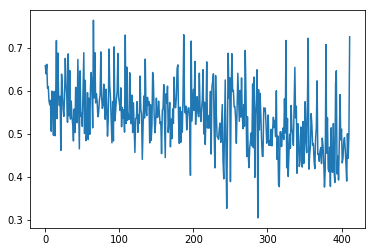

In [13]:
plt.plot(losses[0])

In [14]:
# torch.save(declare.state_dict(), 'demo_model')
# declare.load_state_dict(torch.load('demo_model'))

In [15]:
snopes_eval = DeClareEvaluation(declare, test_dataloader, device)
labels, preds = snopes_eval.claim_wise_accuracies()

In [16]:
true_claim_indices = np.where(labels==1)
false_claim_indices = np.where(labels==0)

In [17]:
accuracy_score(labels[true_claim_indices], preds[true_claim_indices]>0.5)

0.3274336283185841

In [18]:
accuracy_score(labels[false_claim_indices], preds[false_claim_indices]>0.5)

0.6807817589576547

In [19]:
roc_auc_score(labels, preds)

0.4992505260730449

In [20]:
potifact_df = pd.read_csv(POLITIFACT_LOC, sep='\t', header=None)

In [21]:
potifact_df.head()

,0,1,2,3,4,5
0,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,for firms moving overseas in order to create a...,foxnews.com
1,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,get a tax break specifically by outsourcing jo...,newslines.org
2,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,confusing clashes over taxes in wednesday s pr...,wsj.com
3,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,support on this bill in a time of tight budget...,senate.gov
4,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,tax a lower rate for american manufacturing an...,archives.gov


In [22]:
snopes_df = pd.read_csv(SNOPES_LOC, sep='\t', header=None)
snopes_df.head()

,0,1,2,3,4
0,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,there are several holidays throughout that tim...,www.godlikeproductions.com
1,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,defenses against same photographs show images ...,www.sjpba.net
2,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,the best that life could think out we extended...,www.englisher.net
3,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,this entry november 19 2006 published 9 years ...,rss2.com
4,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,place he will not do either said snape the ord...,www.englisher.net
